# [Catastrophic Overfitting Papers](https://ramtinmoslemi.github.io/Catastrophic-Overfitting-Papers/)

A complete list of papers on **Fast Adversarial Training** and **Catastrophic Overfitting**.
You can find the papers and their titles, abstracts, authors, links, and dates stored in [this csv file](https://github.com/RamtinMoslemi/Catastrophic-Overfitting-Papers/blob/main/co_papers.csv).




[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RamtinMoslemi/Catastrophic-Overfitting-Papers/blob/main/CO_Papers.ipynb)
[![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/RamtinMoslemi/Catastrophic-Overfitting-Papers/main/CO_Papers.ipynb)

In [1]:
import re
import requests
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from matplotlib import pyplot as plt

# Extracting from arXiv

In [2]:
# @title Get papers from arXiv

month_converter = {"01": "January", "02": "February", "03": "March",
                   "04": "April", "05": "May", "06": "June",
                   "07": "July", "08": "August", "09": "September",
                   "10": "October", "11": "November", "12": "December"}

# Extracted from Carlini
false_positives = ['https://arxiv.org/abs/2206.02355',
                   'https://arxiv.org/abs/2306.13185',
                   'https://arxiv.org/abs/2402.01297',
                   'https://arxiv.org/abs/2404.16612',
                   'https://arxiv.org/abs/2503.18998']


def get_page_papers(soup):
    page_papers = []

    # Find all paper entries
    paper_entries = soup.find_all('li', {'class': 'arxiv-result'})

    for entry in paper_entries:
        # Extract paper title
        title_tag = entry.find('p', {'class': 'title is-5 mathjax'})
        title = title_tag.text.strip() if title_tag else 'No Title Found'

        # Extract abstract link
        link_tag = entry.find('a', href=True)
        abstract_link = link_tag['href'] if link_tag else 'No Link Found'

        # Extract year and month from the link
        match = re.search(r'(\d{2})(\d{2})\.\d*', abstract_link)
        if match:
            year, month = str(20) + match.group(1), month_converter[match.group(2)]
        else:
            year, month = 'Unknown', 'Unknown'

        # Extract abstract text
        abstract_tag = entry.find('span', {'class': 'abstract-full has-text-grey-dark mathjax'})
        abstract = abstract_tag.text.replace('Abstract:', '').strip() if abstract_tag else "Abstract not found."
        if abstract.endswith('         △ Less'):
            abstract = abstract[:-len('         △ Less')]
        elif abstract.endswith(' △ Less'):
            abstract = abstract[:-len(' △ Less')]

        # Extract author names
        authors_tag = entry.find('p', {'class': 'authors'})
        author_names = []
        if authors_tag:
            author_tags = authors_tag.find_all('a')
            author_names = [author.text.strip() for author in author_tags]
        authors = ', '.join(author_names)

        if abstract_link in false_positives:
            continue
        page_papers.append({'Title': title, 'Abstract': abstract, 'Link': abstract_link, 'Year': year, 'Month': month, 'Authors': authors})
    return page_papers


def extract_paper_info(search_keys=['fast adversarial training', 'catastrophic overfitting', 'single-step adversarial training'], size=200):
    papers = []
    for search_key in search_keys:
        new_papers = []
        search_key = '+'.join(search_key.split())
        url = f'https://arxiv.org/search/?query=%22{search_key}%22&searchtype=all&abstracts=show&order=announced_date_first&size=200'
        while True:
            # Send a GET request to the search URL
            response = requests.get(url + f'&start={len(new_papers)}')
            soup = BeautifulSoup(response.content, 'html.parser')
            # Add paper from this page
            new_papers += get_page_papers(soup)
            # Stop on final page (must be fixed later)
            if len(new_papers) % size != 0:
                break

            print(new_papers)
        papers += new_papers
    return pd.DataFrame(papers).sort_values(by='Link').drop_duplicates(subset='Link', keep='first').reset_index(drop=True)

In [3]:
papers = extract_paper_info()
papers.to_csv('co_papers.csv', index=False)

# Plots

In [4]:
df = pd.read_csv('co_papers.csv')
df

,Title,Abstract,Link,Year,Month,Authors
0,Adversarially Robust Distillation,Knowledge distillation is effective for produc...,https://arxiv.org/abs/1905.09747,2019,May,"Micah Goldblum, Liam Fowl, Soheil Feizi, Tom G..."
1,Fast is better than free: Revisiting adversari...,"Adversarial training, a method for learning ro...",https://arxiv.org/abs/2001.03994,2020,January,"Eric Wong, Leslie Rice, J. Zico Kolter"
2,Regularizers for Single-step Adversarial Training,The progress in the last decade has enabled ma...,https://arxiv.org/abs/2002.00614,2020,February,"B. S. Vivek, R. Venkatesh Babu"
3,Using Single-Step Adversarial Training to Defe...,Adversarial examples have become one of the la...,https://arxiv.org/abs/2002.09632,2020,February,"Guanxiong Liu, Issa Khalil, Abdallah Khreishah"
4,Single-step Adversarial training with Dropout ...,Deep learning models have shown impressive per...,https://arxiv.org/abs/2004.08628,2020,April,"Vivek B. S., R. Venkatesh Babu"
5,Initializing Perturbations in Multiple Directi...,Recent developments in the filed of Deep Learn...,https://arxiv.org/abs/2005.07606,2020,May,"Xunguang Wang, Ship Peng Xu, Eric Ke Wang"
6,Towards Understanding Fast Adversarial Training,Current neural-network-based classifiers are s...,https://arxiv.org/abs/2006.03089,2020,June,"Bai Li, Shiqi Wang, Suman Jana, Lawrence Carin"
7,Understanding and Improving Fast Adversarial T...,A recent line of work focused on making advers...,https://arxiv.org/abs/2007.02617,2020,July,"Maksym Andriushchenko, Nicolas Flammarion"
8,Fast Training of Deep Neural Networks Robust t...,Deep neural networks are capable of training f...,https://arxiv.org/abs/2007.03832,2020,July,"Justin Goodwin, Olivia Brown, Victoria Helus"
9,Efficient Robust Training via Backward Smoothing,Adversarial training is so far the most effect...,https://arxiv.org/abs/2010.01278,2020,October,"Jinghui Chen, Yu Cheng, Zhe Gan, Quanquan Gu, ..."


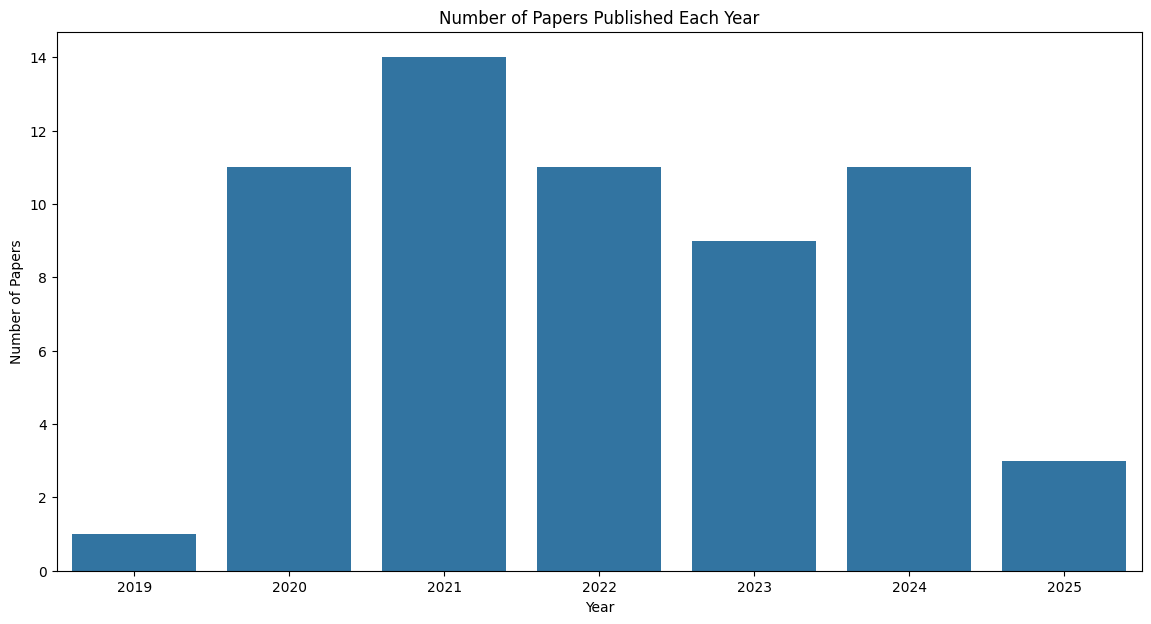

In [5]:
# Group by Year and count the number of papers
monthly_counts = df.groupby(['Year'], observed=False).size().reset_index(name='Counts')

# Create the plot
plt.figure(figsize=(14, 7))

sns.barplot(data=monthly_counts, x='Year', y='Counts')

plt.title('Number of Papers Published Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.savefig('paper_by_year.svg')
plt.show()

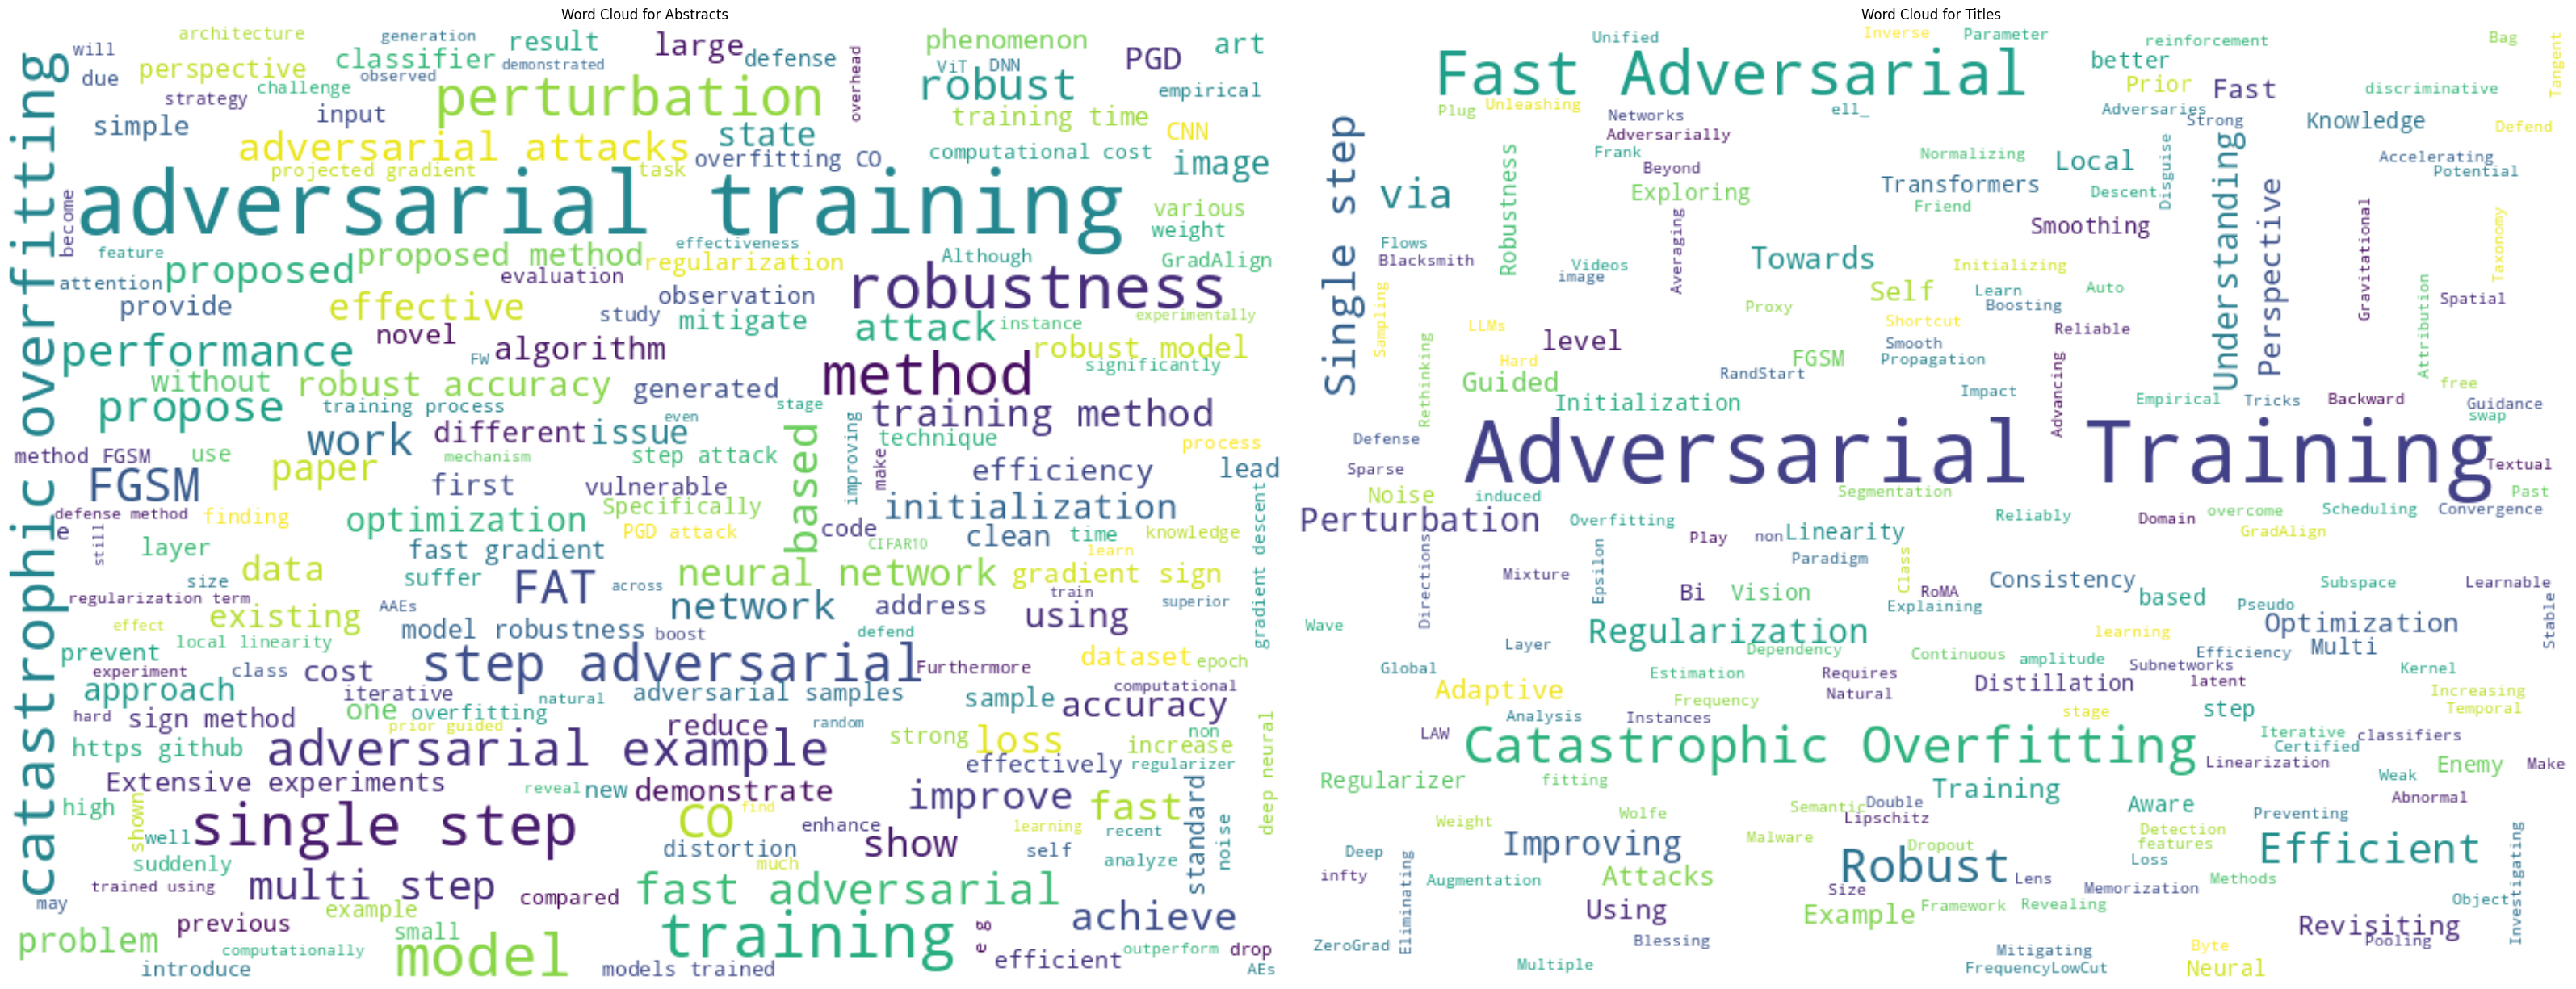

In [6]:
# Generate word cloud for abstracts
abstract_text = " ".join(df['Abstract'].dropna().tolist())
wordcloud_abstract = WordCloud(width=800, height=600, background_color='white').generate(abstract_text)

# Generate word cloud for titles
title_text = " ".join(df['Title'].dropna().tolist())
wordcloud_title = WordCloud(width=800, height=600, background_color='white').generate(title_text)

# Plot the word clouds
plt.figure(figsize=(32, 13))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_abstract, interpolation='bilinear')
plt.title('Word Cloud for Abstracts')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_title, interpolation='bilinear')
plt.title('Word Cloud for Titles')
plt.axis('off')

plt.tight_layout()
plt.savefig('word_clouds.png')
plt.show()

# README

In [7]:
# @title create read me file
def create_readme():
    year, month = None, None
    header = '# Catastrophic Overfitting Papers\nA complete list of papers on **Fast Adversarial Training** and **Catastrophic Overfitting** submitted to arXiv.\nYou can find the papers and their titles, abstracts, authors, links, and dates stored in [this csv file](https://github.com/RamtinMoslemi/Catastrophic-Overfitting-Papers/blob/main/co_papers.csv).\n\n'
    header += '## Paper Counts by Year\nNumber of papers submitted to arXiv by year.\n\n![yearly_papers](figures/paper_by_year.svg)\n\n'
    header += '## Word Clouds\nWord clouds of paper titles and abstracts.\n\n![word_clouds](figures/word_clouds.png)\n\n'
    header += '## Notebook\nYou can play with the notebook:\n\n'
    header += '[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RamtinMoslemi/Catastrophic-Overfitting-Papers/blob/main/CO_Papers.ipynb) [![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/RamtinMoslemi/Catastrophic-Overfitting-Papers/main/CO_Papers.ipynb)\n\n\n'
    with open('README.md', 'w', encoding='utf-8') as file:
        file.write(header)
        for i in range(len(df)):
            if df.iloc[i]['Year'] != year:
                year = df.iloc[i]['Year']
                file.write(f'# {year}\n')
            if df.iloc[i]['Month'] != month:
                month = df.iloc[i]['Month']
                file.write(f'## {month}\n')
            file.write(f"### [{df.iloc[i]['Title']}]({df.iloc[i]['Link']})\n\n")
            if len(df.iloc[i]['Authors'].split(',')) != 1:
                file.write(f"**Authors:**\n{df.iloc[i]['Authors']}\n\n")
            else:
                file.write(f"**Author:**\n{df.iloc[i]['Authors']}\n\n")
            file.write(f"**Abstract:**\n{df.iloc[i]['Abstract']}\n\n\n")

In [8]:
create_readme()

# Carlini

Searching papers from [A Complete List of All (arXiv) Adversarial Example Papers](https://nicholas.carlini.com/writing/2019/all-adversarial-example-papers.html) by [Nicholas Carlini](https://nicholas.carlini.com).

In [9]:
! gdown https://nicholas.carlini.com/writing/2019/advex_papers.json

Downloading...
From: https://nicholas.carlini.com/writing/2019/advex_papers.json
To: /content/advex_papers.json
19.6MB [00:00, 43.0MB/s]


In [10]:
import json
from tqdm.notebook import tqdm

def is_relevant(string, keys):
    for key in keys:
      if string.lower().find(key) != -1:
          return True
    return False

def get_co_papers(addr='advex_papers.json'):
    # Open and read the JSON file
    with open(addr, 'r') as file:
        data = json.load(file)
    # Find relevant papers
    keys = ['catastrophic overfitting', 'fast adversarial training',
            'single-step adversarial training']
    co_papers = {'Date': [], 'Link': [], 'Title': [], 'Authors': [], 'Abstract': []}
    for paper in (pbar := tqdm(data[::-1])):
        if is_relevant(paper[2], keys) or is_relevant(paper[-1], keys):
            for idx, key in enumerate(co_papers):
                co_papers[key].append(paper[idx])
            pbar.set_description(f"Found {len(co_papers['Date'])} relevant papers")
    return pd.DataFrame(co_papers)

In [11]:
co_papers = get_co_papers()
search_results = [link.split('/')[-1] for link in df['Link']]

for paper in co_papers.iterrows():
    if paper[1]['Link'].split('/')[-1] not in search_results:
        print(paper[1]['Title'], paper[1]['Link'])

  0%|          | 0/12311 [00:00<?, ?it/s]

Possible false positives.

In [12]:
diff = 0

for i in range(min(len(df), len(co_papers))):
    if df.iloc[i]['Link'].split('/')[-1] != co_papers.iloc[i - diff]['Link'].split('/')[-1]:
        print(i, df.iloc[i]['Title'], df.iloc[i]['Link'])
        diff += 1

for i in range(min(len(df), len(co_papers)), len(df)):
    print(i, df.iloc[i]['Title'], df.iloc[i]['Link'])

11 Understanding and Increasing Efficiency of Frank-Wolfe Adversarial Training https://arxiv.org/abs/2012.12368
19 Adaptive perturbation adversarial training: based on reinforcement learning https://arxiv.org/abs/2108.13239
42 Learn from the Past: A Proxy Guided Adversarial Defense Framework with Self Distillation Regularization https://arxiv.org/abs/2310.12713
45 Rethinking Adversarial Training with Neural Tangent Kernel https://arxiv.org/abs/2312.02236
56 Adaptive Epsilon Adversarial Training for Robust Gravitational Wave Parameter Estimation Using Normalizing Flows https://arxiv.org/abs/2412.07559
57 RoMA: Robust Malware Attribution via Byte-level Adversarial Training with Global Perturbations and Adversarial Consistency Regularization https://arxiv.org/abs/2502.07492
58 Fast Adversarial Training against Sparse Attacks Requires Loss Smoothing https://arxiv.org/abs/2502.21041
59 Fast Adversarial Training with Weak-to-Strong Spatial-Temporal Consistency in the Frequency Domain on Vide

In [13]:
false_positives = ['https://arxiv.org/abs/2206.02355',
                   'https://arxiv.org/abs/2306.13185',
                   'https://arxiv.org/abs/2402.01297',
                   'https://arxiv.org/abs/2404.16612',
                   'https://arxiv.org/abs/2503.18998']